# Методы детекции дрейфа данных

In [1]:
import numpy as np
from numpy import quantile, random, where
import pandas as pd
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, gc, warnings, random

## Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import eli5

from scipy import stats

## river
from river.drift import ADWIN, DDM, EDDM

## Turn off warnings
warnings.filterwarnings('ignore')

## SEEDer
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

seed_everything()

%matplotlib inline

# Данные

Протестируем некоторые методы детекции дрейфа на двух синтетических потоках данных: с резким дрейфом и постепенным дрейфом. 

### Данные с резким дрейфом

Для создания потока данных с резким дрейфом объединим 3 распределения по 1000 образцов в каждом:

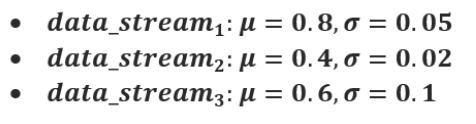

In [2]:
random_state = np.random.RandomState(seed=42)

data_stream_1 = random_state.normal(0.8, 0.05, 1000)
data_stream_2 = random_state.normal(0.4, 0.02, 1000)
data_stream_3 = random_state.normal(0.6, 0.1, 1000)

data_stream_abrupt_drift = np.concatenate((data_stream_1, data_stream_2, data_stream_3))

Отобразим поток данных с резким дрейфом на распределения на графиках

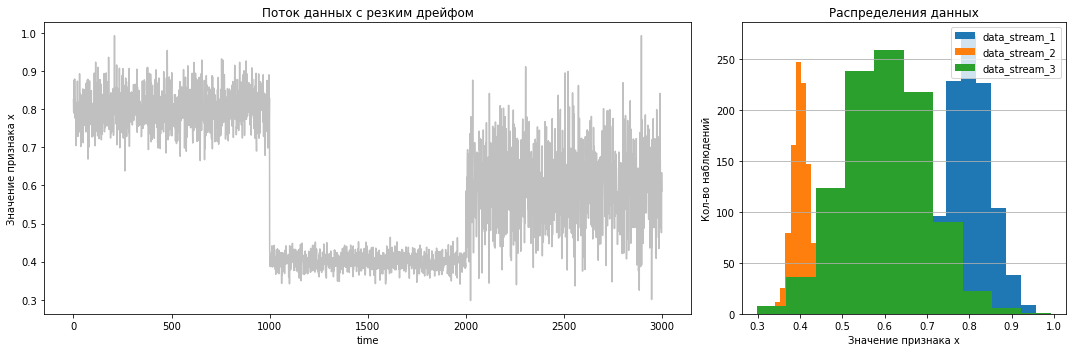

In [14]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
ax1, ax2 = plt.subplot(gs[0], title='Поток данных с резким дрейфом'), plt.subplot(gs[1], title='Распределения данных')
ax1.plot(data_stream_abrupt_drift, color='silver')
ax1.set_xlabel('time')
ax1.set_ylabel('Значение признака x')
ax2.grid(axis='y')
ax2.hist(data_stream_1, label='data_stream_1')
ax2.hist(data_stream_2, label='data_stream_2')
ax2.hist(data_stream_3, label='data_stream_3')
ax2.set_xlabel('Значение признака x')
ax2.set_ylabel('Кол-во наблюдений')
ax2.legend()
plt.show()

### Данные с постепенным дрейфом

Для создания потока данных с постепенным дрейфом построим график синусоиды и добавим к нему шум.

In [10]:
# За основу возьмем график синусоиды
y = lambda x: 1/2*np.sin(x)
x = np.linspace(-1.8, 1.5, 3000)
sin_x = y(x)

# Сгенерируем шум и добавим его к синусоиде
random_state = np.random.RandomState(seed=42)
row = random_state.normal(0.8, 0.05, 3000)

data_stream_slow_drift = row + sin_x
slow_drift_1 = data_stream_slow_drift[:1000]
slow_drift_2 = data_stream_slow_drift[1000:2000]
slow_drift_3 = data_stream_slow_drift[2000:3000]

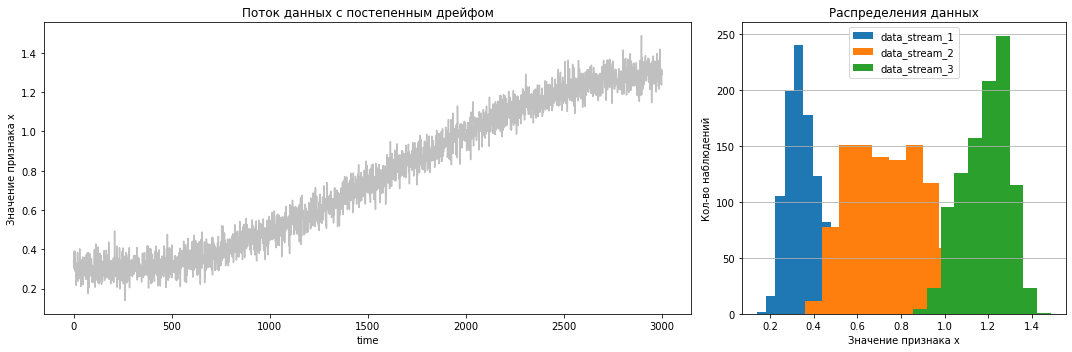

In [11]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
ax1, ax2 = plt.subplot(gs[0], title='Поток данных с постепенным дрейфом'), plt.subplot(gs[1], title='Распределения данных')
ax1.plot(data_stream_slow_drift, color='silver')
ax1.set_xlabel('time')
ax1.set_ylabel('Значение признака x')
ax2.grid(axis='y')
ax2.hist(slow_drift_1, label='data_stream_1')
ax2.hist(slow_drift_2, label='data_stream_2')
ax2.hist(slow_drift_3, label='data_stream_3')
ax2.set_xlabel('Значение признака x')
ax2.set_ylabel('Кол-во наблюдений')
ax2.legend()
plt.show()

In [19]:
train_slow_drift = data_stream_slow_drift[:500]
test_slow_drift = data_stream_slow_drift[500:1500]

## Методы обнаружения дрейфа в потоковых данных

Для данной задачи используем библиотеку River

In [16]:
def stream_drift_detecton(data_stream, drift_detector, reset_after_drift=False):
    """
    Функция для выявления дрейфа в потоке данных, 
    на выходе возвращает список с индексами элементов, на которых произошла детекция дрейфа.
    
    data_stream - поток данных
    drift_detector - метод детекции дрейфа из библиотеки River
    reset_after_drift - очистить drift_detector после обнаружения дрейфа, 
                        т.е. после детекции дрейфа все данные до дрефа в дальнейшем анализе не используются.
    """
    drift_index = []
    for i, val in enumerate(data_stream):
        drift_detector.update(val) 
        # Метод update добавляет значение элемента в окно, обновляет соответствующую статистику, 
        # в данном случае общую сумму всех значений, среднее, ширину окна и общую дисперсию.
        if drift_detector.change_detected:
            # Детектор дрейфа указывает после каждой выборки, есть ли дрейф в данных
            print(f'Зафиксирован дрейф на индексе {i}')
            drift_index.append(i)
            if reset_after_drift:
                # Сброс детектора изменений
                drift_detector.reset()
            
    return drift_index

In [11]:
# Функция для визуализации детекции дрейфа с точками
def final_chart_dots(data_stream, drift_index, drift_values, names, abrupt_drift=False):
    fig = plt.figure(figsize=(10,5), tight_layout=True)
    plt.title(names['title'])
    plt.xlabel(names['xlabel'])
    plt.ylabel(names['ylabel'])
    plt.plot(data_stream, label=names['label'], color='silver', linewidth=1)
    plt.scatter(drift_index, drift_values, color='r', label='Зона детекции дрейфа/аномалии', zorder=2, s=30)
    if abrupt_drift:
        plt.vlines(drift_index_fact, ymin=min(data_stream), ymax=max(data_stream), 
                   colors='black', linestyles='dashed', lw=2, zorder=5, label='Зона фактического дрейфа')
    plt.legend()
    plt.show()

In [12]:
# Фактические значения дрейфа в потоке данных с резким дрейфом
drift_index_fact = [1000, 2000]

### ADWIN

Этот подход используется с потоковыми данными, когда большое количество данных поступает непрерывно и невозможно сохранить их все. При этом данные могут меняться очень быстро. 

ADWIN использует метод скользящего окна для обнаружения дрейфа данных. Размер окна фиксирован, и ADWIN сдвигает фиксированное окно для обнаружения любых изменений во вновь поступающих данных. Когда два окна показывают разные средние значения в новых наблюдениях, старое окно закрывается.

Определяемый пользователем порог устанавливается для срабатывания предупреждения об обнаружении дрейфа. Если абсолютная разница между двумя средними значениями, полученными из двух дополнительных окон, превышает предварительно определенный порог, генерируется сигнал тревоги. 

In [42]:
drift_index_adwin_a = stream_drift_detecton(data_stream_abrupt_drift, ADWIN(), reset_after_drift=True)
drift_values_adwin_a = data_stream_abrupt_drift[drift_index_adwin_a]

Зафиксирован дрейф на индексе 1055
Зафиксирован дрейф на индексе 2079


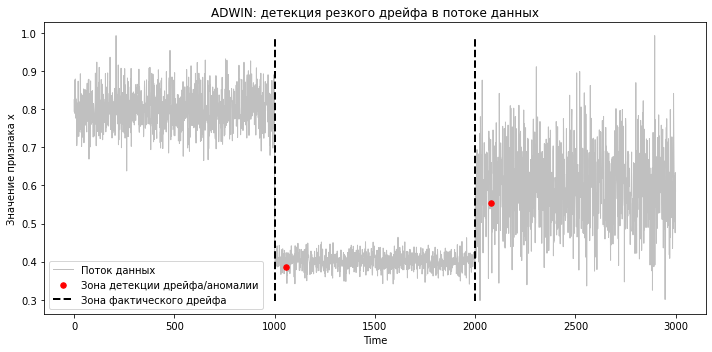

In [43]:
names_adwin_a = {'title':  'ADWIN: детекция резкого дрейфа в потоке данных',
                 'xlabel': 'Time',
                 'ylabel': 'Значение признака x',
                 'label':  'Поток данных'}

final_chart_dots(data_stream_abrupt_drift, drift_index_adwin_a, drift_values_adwin_a, names_adwin_a, abrupt_drift=True)

Как видно, ADWIN довольно быстро заметил резкий дрейф данных.

### Постепенный дрейф

In [44]:
drift_index_adwin_s = stream_drift_detecton(data_stream_slow_drift, ADWIN(), reset_after_drift=True)
drift_values_adwin_s = data_stream_slow_drift[drift_index_adwin_s]

Зафиксирован дрейф на индексе 895
Зафиксирован дрейф на индексе 1375
Зафиксирован дрейф на индексе 1823
Зафиксирован дрейф на индексе 2271
Зафиксирован дрейф на индексе 2783


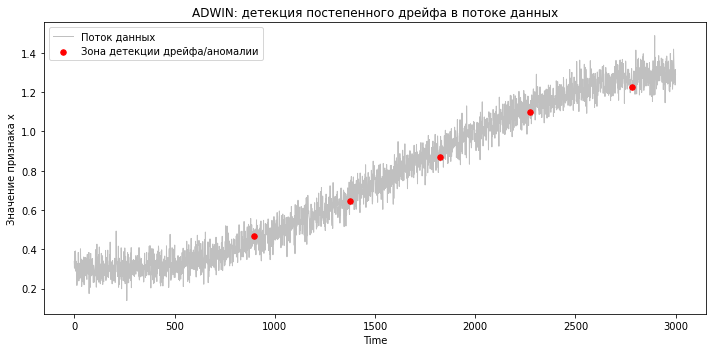

In [45]:
names_adwin_a = {'title':  'ADWIN: детекция постепенного дрейфа в потоке данных',
                 'xlabel': 'Time',
                 'ylabel': 'Значение признака x',
                 'label':  'Поток данных'}

final_chart_dots(data_stream_slow_drift, drift_index_adwin_s, drift_values_adwin_s, names_adwin_a)

### DDM

Подход эффективен при обнаружении резких изменений или изменений средней скорости, но с ним возникают трудности при медленных изменениях. В этом случае примеры будут храниться очень долго, запуск уровня дрейфа начнёт занимать слишком много времени, а память может быть превышена.

Метод основан на модели обучения, согласно которой частота ошибок модели будет уменьшаться по мере увеличения количества анализируемых выборок, пока распределение данных является стационарным.

Если алгоритм обнаруживает увеличение частоты ошибок, которое превышает расчетный порог, он предупреждает пользователя о том, что дрейф концепции может произойти в ближайшем будущем. Это называется зоной предупреждения.

Поскольку DDM и EDDM анализируют частоту ошибок модели, на вход они получают поток из нулей и единиц, где 1 - модель ошиблась, а 0 - ошибки нет.

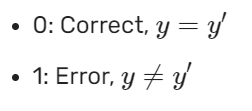
Создадим 2 потока ошибок модели: с резким дрейфом и с постепенным дрейфом.

#### Резкий дрейф

In [26]:
# Поток данных по ошибкам модели (1 - модель ошиблась, 0 - модель не ошиблась). 
# Необходим для методов, которые получают навход поток данных по ошибкам модели
error_predictions_1 = np.random.binomial(1, 0.2, 1000)
error_predictions_2 = np.random.binomial(1, 0.5, 1000)
error_predictions_3 = np.random.binomial(1, 0.9, 1000)

error_predictions_stream = np.concatenate((error_predictions_1, error_predictions_2, error_predictions_3))

Вычислим Prequential error для визулизации работы метода, основанного на частоте ошибок

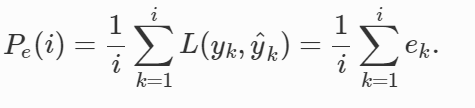

In [27]:
cumsum_error = np.cumsum(error_predictions_stream)

prequential_error = []
for i in range(len(cumsum_error)):
    prequential_error.append( 1/(i+1) * cumsum_error[i] )

In [28]:
drift_index_ddm = stream_drift_detecton(error_predictions_stream, DDM())

Зафиксирован дрейф на индексе 1074
Зафиксирован дрейф на индексе 2336


In [29]:
drift_values_ddm = np.array(prequential_error)[drift_index_ddm]

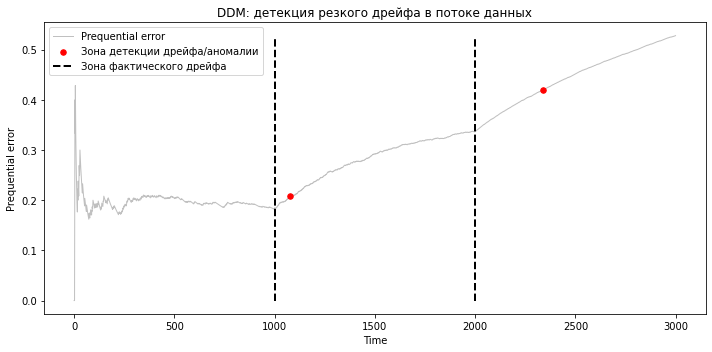

In [30]:
names_DDM_a = {'title':  'DDM: детекция резкого дрейфа в потоке данных',
               'xlabel': 'Time',
               'ylabel': 'Prequential error',
               'label':  'Prequential error'}

final_chart_dots(prequential_error, drift_index_ddm, drift_values_ddm, names_DDM_a, abrupt_drift=True)

Пробую другой подход

### Медленный дрейф

Создадим поток ошибок модели с медленным дрейфом. Для этого сгенерируем поток данных с биноминальным распределнием, где через каждые 200 наблюдений вероятность ошибки увеличивается на 0.1.

In [35]:
l=[]
for p in np.arange(0.1, 1.1, 0.1):
    l.extend(np.random.binomial(1, p, 200))
error_predictions_slow = np.array(l)

In [36]:
cumsum_error_slow = np.cumsum(error_predictions_slow)

prequential_error_slow = []
for i in range(len(cumsum_error_slow)):
    prequential_error_slow.append( 1/(i+1) * cumsum_error_slow[i] )

In [37]:
drift_index_ddm_slow = stream_drift_detecton(error_predictions_slow, DDM())

Зафиксирован дрейф на индексе 479
Зафиксирован дрейф на индексе 691
Зафиксирован дрейф на индексе 892
Зафиксирован дрейф на индексе 1051
Зафиксирован дрейф на индексе 1826


In [38]:
drift_values_ddm_slow = np.array(prequential_error_slow)[drift_index_ddm_slow]

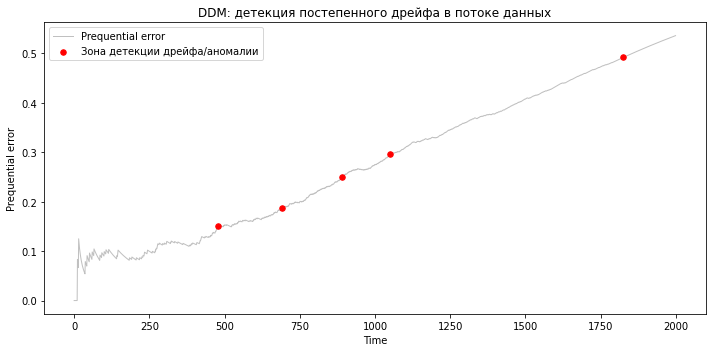

In [39]:
names_DDM_s = {'title':  'DDM: детекция постепенного дрейфа в потоке данных',
              'xlabel': 'Time',
              'ylabel': 'Prequential error',
              'label':  'Prequential error'}

final_chart_dots(prequential_error_slow, drift_index_ddm_slow, drift_values_ddm_slow, names_DDM_s)

DDM также видит медленный дрейф

### EDDM

#### Резкий дрейф

In [14]:
drift_index_eddm = stream_drift_detecton(error_predictions_stream, EDDM())

Зафиксирован дрейф на индексе 140
Зафиксирован дрейф на индексе 286
Зафиксирован дрейф на индексе 1044
Зафиксирован дрейф на индексе 1158
Зафиксирован дрейф на индексе 1230
Зафиксирован дрейф на индексе 2058
Зафиксирован дрейф на индексе 2109


In [15]:
drift_values_eddm = np.array(prequential_error)[drift_index_eddm]

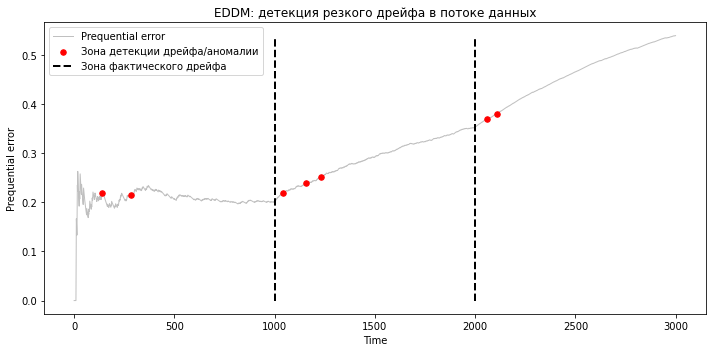

In [16]:
names_EDDM_a = { 'title':  'EDDM: детекция резкого дрейфа в потоке данных',
                 'xlabel': 'Time',
                 'ylabel': 'Prequential error',
                 'label':  'Prequential error'}

final_chart_dots(prequential_error, drift_index_eddm, drift_values_eddm, names_EDDM_a, abrupt_drift=True)

#### Медленный дрейф

In [317]:
drift_index_eddm_slow = stream_drift_detecton(error_predictions_slow, EDDM())

Зафиксирован дрейф на индексе 293
Зафиксирован дрейф на индексе 530
Зафиксирован дрейф на индексе 640
Зафиксирован дрейф на индексе 711
Зафиксирован дрейф на индексе 807
Зафиксирован дрейф на индексе 879
Зафиксирован дрейф на индексе 1031
Зафиксирован дрейф на индексе 1094
Зафиксирован дрейф на индексе 1154
Зафиксирован дрейф на индексе 1217
Зафиксирован дрейф на индексе 1264
Зафиксирован дрейф на индексе 1324
Зафиксирован дрейф на индексе 1377
Зафиксирован дрейф на индексе 1417
Зафиксирован дрейф на индексе 1641
Зафиксирован дрейф на индексе 1688
Зафиксирован дрейф на индексе 1753
Зафиксирован дрейф на индексе 1801


In [320]:
drift_values_eddm_slow = np.array(prequential_error_slow)[drift_index_eddm_slow]

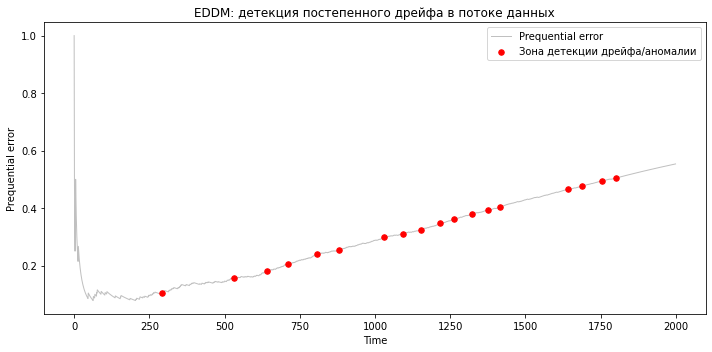

In [364]:
names_EDDM_s = { 'title':  'EDDM: детекция постепенного дрейфа в потоке данных',
                 'xlabel': 'Time',
                 'ylabel': 'Prequential error',
                 'label':  'Prequential error'}
final_chart_dots(prequential_error_slow, drift_index_eddm_slow, drift_values_eddm_slow, names_EDDM_s)

EDDM также хорошо справляется с медленным дрейфом и имеет большую чувствительность по сравнению с DDM

## Статистические методы

Этот подход использует различные статистические показатели, чтобы сделать вывод о том, отличается ли распределение обучающих данных от распределения производственных данных. Данные уже собраны, поэтому обычно каждый раз выполняется один и тот же расчет и, возможно, построение результатов для упрощения анализа.

Поскольку для этих методов не нужна метка и не требуется дополнительная память, то можно получить быстрый индикатор изменения входных/выходных признаков. Это помогает начать исследование ситуации еще до любого потенциального ухудшения показателей производительности модели. С другой стороны, отсутствие метки и игнорирование памяти о прошлых событиях и других функциях может привести к ложным срабатываниям при неправильном обращении.

Вот некоторые из популярных статистических методов для расчета разницы между двумя любыми популяциями.

 ### Kolmogorov-Smirnov (K-S) test:

In [17]:
def ks_test(old_data, new_data, p_value=0.05):
    test = stats.ks_2samp(old_data, new_data)
    if test[1] < p_value:
        print('Распределения двух наборов данных различны')
    else:
        print('В распределении обоих наборов данных нет изменений или сдвигов')
    return test

#### Резкий дрейф

In [23]:
ks_test(data_stream_1, data_stream_2)

Распределения двух наборов данных различны


KstestResult(statistic=1.0, pvalue=0.0)

#### Постепенный дрейф:

In [22]:
ks_test(train_slow_drift, test_slow_drift)

Распределения двух наборов данных различны


KstestResult(statistic=0.709, pvalue=1.7763568394002505e-15)

### Population Stability Index:

#### ШАГИ ДЛЯ РАСЧЕТА ИНДЕКСА PSI

1. Сортируем старый набор данных по убыванию
2. Разделяем старый набор данных на бакеты (лучше на 10 или 20)
3. Рассчитываем процент записей старого набора данных в каждом бакете (%Expected)
4. Рассчитываем процент записей нового набора данных в каждом бакете (%Actual)
5. Рассчитываем значение PSI по формуле:
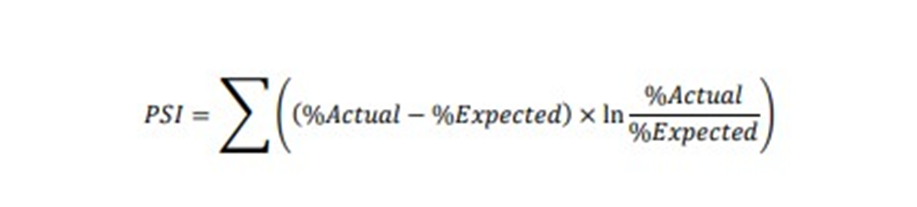
6. Интерпретируем результаты по следующей логике:
     - PSI<=0,1: в распределении обоих наборов данных нет изменений или сдвигов.

     - 0,1< PSI<0,2: небольшое изменение или сдвиг.

     - PSI>0,2: между обоими наборами данных произошел значительный сдвиг в распределении.


In [88]:
def calculate_psi(old_data, new_data, buckets=10, axis=0):
    # Разделяем старый набор данных на бакеты
    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    breakpoints += -(np.min(breakpoints))
    breakpoints /= np.max(breakpoints) / (np.max(old_data) - np.min(old_data))
    breakpoints += np.min(old_data)

    # Рассчитываем процент записей старого набора данных в каждом бакете
    old_percents = np.histogram(old_data, breakpoints)[0] / len(old_data)
    # Рассчитываем процент записей нового набора данных в каждом бакете
    new_percents = np.histogram(new_data, breakpoints)[0] / len(new_data)

    # Рассчитываем значение PSI
    def sub_psi(old_perc, new_perc):
        if new_perc == 0:
            new_perc = 0.0001
        if old_perc == 0:
            old_perc = 0.0001
        value = (old_perc - new_perc) * np.log(old_perc / new_perc)
        return(value)

    psi_value = np.sum(sub_psi(old_percents[i], new_percents[i]) for i in range(0, len(old_percents)))
        
    # Интерпретируем результаты
    if psi_value <= 0.1:
        print('В распределении обоих наборов данных нет изменений или сдвигов')
    elif psi_value > 0.2 :
        print('Распределения двух наборов данных имеют значительные различия')
    else:
        print('В распределении наборов данных есть небольшое изменение или сдвиг')
    
    return(psi_value)

#### Резкий дрейф

In [89]:
calculate_psi(data_stream_1, data_stream_2)

Распределения двух наборов данных имеют значительные различия


7.437140212812651

#### Постепенный дрейф:

In [90]:
calculate_psi(train_slow_drift, test_slow_drift)

Распределения двух наборов данных имеют значительные различия


1.97506549976516

## Adversarial validation

Этот подход включает в себя обучение модели классификации, помогающей определить, похожи ли определенные точки данных на другой набор точек данных. Если модель с трудом различает данные, то существенного дрейфа данных нет. Если модель способна правильно разделить группы данных, то, вероятно, некоторый дрейф данных существует.

Данные, которые использовались для построения текущей модели в производстве, нужно пометить как 0, а данные в реальном времени — как 1. После этого необходимо построить модель классификации и оценить результаты.

Если модель дает высокую точность, это означает, что она может легко различать два набора данных. Таким образом, можно заключить, что произошел дрейф данных, и модель следует переобучить. С другой стороны, если точность модели ROC-AUC составляет около 0,5, это означает, что значительного сдвига данных не произошло, и можно продолжать использовать текущую модель.

Недостатком этого подхода является то, что каждый раз, когда становятся доступными новые входные данные, необходимо повторять процесс обучения и тестирования, что может быть дорогостоящим и трудозатратным.


#### Резкий дрейф

In [25]:
data_stable_1 = random_state.normal(0.5, 0.05, 1000)
data_stable_2 = random_state.normal(0.5, 0.05, 1000)

df_old = pd.DataFrame({'feat1': data_stream_1, 'feat2': data_stable_1, 'target': 1})
df_new = pd.DataFrame({'feat1': data_stream_2, 'feat2': data_stable_2, 'target': 0})
df_abrupt_drift = pd.concat([df_old, df_new]).reset_index(drop=True)

In [74]:
df_abrupt_drift

,feat1,feat2,target
0,0.824836,0.404610,1
1,0.793087,0.456981,1
2,0.832384,0.479320,1
3,0.876151,0.594384,1
4,0.788292,0.527828,1
...,...,...,...
1995,0.421403,0.497552,0
1996,0.399470,0.535571,0
1997,0.382363,0.655646,0
1998,0.396739,0.540402,0


Обучим модель распознавать один пакет данных от другого

In [26]:
model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
adv_validation_scores = cross_val_score(model, 
                                        df_abrupt_drift[['feat1', 'feat2']], 
                                        df_abrupt_drift['target'], 
                                        cv=skf, 
                                        n_jobs=4,
                                        scoring='roc_auc')

In [27]:
model.fit( df_abrupt_drift[['feat1', 'feat2']], df_abrupt_drift['target'] )

RandomForestClassifier(n_jobs=4, random_state=17)

In [28]:
adv_validation_scores.mean()

1.0

Мы видим, что два этих набора данных различны, при этом дрейфующий признак feat1 имеет высокую значимость в данном различии:

In [29]:
eli5.show_weights(estimator=model, feature_names=list(df_abrupt_drift[['feat1', 'feat2']]))

Weight,Feature
0.9902 ± 0.0295,feat1
0.0098 ± 0.0295,feat2


#### Постепенный дрейф:

In [30]:
df_old = pd.DataFrame({'feat1': data_stream_slow_drift[:1000], 'feat2': data_stable_1, 'target': 1})
df_new = pd.DataFrame({'feat1': data_stream_slow_drift[1000:2000], 'feat2': data_stable_2, 'target': 0})
df_slow_drift = pd.concat([df_old, df_new]).reset_index(drop=True)

In [31]:
model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
adv_validation_scores_slow = cross_val_score(model, df_slow_drift[['feat1', 'feat2']], 
                                        df_slow_drift['target'], cv=skf, n_jobs=4,
                                        scoring='roc_auc')

In [32]:
model.fit(df_slow_drift[['feat1', 'feat2']], df_slow_drift['target'])

RandomForestClassifier(n_jobs=4, random_state=17)

In [33]:
adv_validation_scores_slow.mean()

0.983155

Мы видим, что два этих пакета данных различны, при этом Drifted_data имеет высокую значимость в данном различии:

In [34]:
eli5.show_weights(estimator=model, feature_names=list(df_slow_drift[['feat1', 'feat2']]))

Weight,Feature
0.9270 ± 0.0327,feat1
0.0730 ± 0.0327,feat2


## Isolation Forest

In [49]:
ds_abr = data_stream_abrupt_drift.reshape([-1,1])

### Isolation Forest с плавающим окном на агрегированных статистических показателях потока данных c резким дрейфом

In [51]:
# Подсчет агрегированных показателей:
n_agg = 20
data = ds_abr

mean_agg = []
std_agg  = []
max_agg  = []
min_agg  = []
agg_25   = []
agg_50   = []
agg_75   = []

i1 = 0
i2 = i1 + n_agg

while i2 < len(data):
    mean_agg.append( data[i1:i2].mean() )
    std_agg.append( data[i1:i2].std() )
    min_agg.append( data[i1:i2].min() )
    max_agg.append( data[i1:i2].max() )
    agg_25.append( np.quantile(data[i1:i2], 0.25) )
    agg_50.append( np.quantile(data[i1:i2], 0.5) )
    agg_75.append( np.quantile(data[i1:i2], 0.75) )

    i1 = i2
    i2 = i1 + n_agg

arr = [mean_agg, std_agg, min_agg, max_agg, agg_25, agg_50, agg_75]
data_agg = np.array(arr).T

Обучение с использованием окна

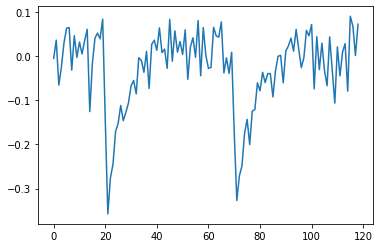

In [52]:
pred_data_agg = []
window_size = 30

for i in range( len(data_agg) - window_size ):
    # Обучаем модель на предыдущем окне
    model  = IsolationForest(random_state=0).fit(data_agg[i: i + window_size])
    # Делаем предсказания для текущего наблюдения
    preds = list(model.decision_function(data_agg[i + window_size].reshape([1, -1])))
    pred_data_agg = pred_data_agg + preds
plt.plot(pred_data_agg)
plt.show()

In [53]:
# Обозначим порог отсечения зоны аномалии так, чтобы оставить 5 точек с наибольшей (а фактически наименьшей) оценкой аномалии
threshold = np.quantile(pred_data, q = 5/len(pred_data_agg))

# оставим только значения оценки аномалии, запишем их в volume
vol = np.array([0 if pred >= threshold else pred for pred in pred_data_agg])
volume = -vol[vol<0].reshape(-1, 1)

# Индексы дрейфа
outlier_index = where(vol<0)

# Трансформируем индексы таким образом, чтобы можно было показать дрейф на полном потоке данных, 
# а не на агрегированных/сдвинутых показателях данного потока
index_calculation = lambda t: (t + window_size + 1) * n_agg
outlier_index_full = [index_calculation(x) for x in outlier_index][0]
# Значения точки данных, где выявлен дрейф (значение оси y на нашем графике)
values = ds_abr[outlier_index_full].reshape(1, -1)[0]

# Для того, чтобы сделать отобразить на графике точки дрейфа с разной прозрачностью и размером в зависимости от оценки аномалии
# Трансформируем значения оценки аномалии посредством MinMaxScaler
scaler = MinMaxScaler(feature_range=(min(volume), 1))
scaler = scaler.fit(volume)
normalized_volume = scaler.transform(volume)

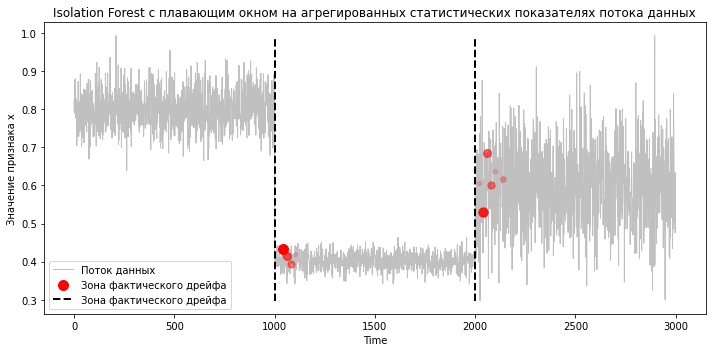

In [55]:
fig = plt.figure(figsize=(10,5), tight_layout=True)
plt.title('Isolation Forest с плавающим окном на агрегированных статистических показателях потока данных')
plt.xlabel('Time')
plt.ylabel('Значение признака x')
plt.plot(ds_abr, label='Поток данных', color='silver', linewidth=1)
for index, x in enumerate(outlier_index_full):
    plt.scatter(x = x, y = values[index], c = 'red', alpha = normalized_volume[index], s=normalized_volume[index]*100, zorder=2,
               label='Зона фактического дрейфа' if index == 0 else None)
plt.vlines(drift_index_fact, ymin=min(ds_abr), ymax=max(ds_abr), 
           colors='black', linestyles='dashed', lw=2, zorder=5, label='Зона фактического дрейфа')
plt.legend()
plt.show()

### Isolation Forest с плавающим окном на агрегированных статистических показателях потока данных с постепенным дрейфом

In [56]:
# Данные
ds_slow = data_stream_slow_drift.reshape([-1,1])

In [57]:
# Подсчет агрегированных показателей:
n_agg = 20
data = ds_slow

mean_agg = []
std_agg  = []
max_agg  = []
min_agg  = []
agg_25   = []
agg_50   = []
agg_75   = []

i1 = 0
i2 = i1 + n_agg

while i2 < len(data):
    mean_agg.append( data[i1:i2].mean() )
    std_agg.append( data[i1:i2].std() )
    min_agg.append( data[i1:i2].min() )
    max_agg.append( data[i1:i2].max() )
    agg_25.append( np.quantile(data[i1:i2], 0.25) )
    agg_50.append( np.quantile(data[i1:i2], 0.5) )
    agg_75.append( np.quantile(data[i1:i2], 0.75) )

    i1 = i2
    i2 = i1 + n_agg

arr = [mean_agg, std_agg, min_agg, max_agg, agg_25, agg_50, agg_75]
data_agg = np.array(arr).T

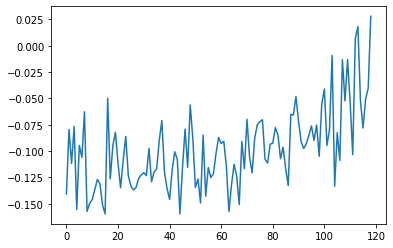

In [58]:
pred_data_agg = []
window_size = 30

for i in range( len(data_agg) - window_size ):
    # Обучаем модель на предыдущем окне
    model  = IsolationForest(random_state=0).fit(data_agg[i: i + window_size])
    # Делаем предсказания для текущего наблюдения
    preds = list(model.decision_function(data_agg[i + window_size].reshape([1, -1])))
    pred_data_agg = pred_data_agg + preds
plt.plot(pred_data_agg)
plt.show()

In [59]:
# Выберем экспертно порог отсечения зоны аномалии
threshold = -0.125

# оставим только значения оценки аномалии, запишем их в volume
vol = np.array([0 if pred >= threshold else pred for pred in pred_data_agg])
volume = -vol[vol<0].reshape(-1, 1)

# Индексы дрейфа
outlier_index = where(vol<0)

# Трансформируем индексы таким образом, чтобы можно было показать дрейф на полном потоке данных, 
# а не на агрегированных/сдвинутых показателях данного потока
index_calculation = lambda t: (t + window_size + 1) * n_agg
outlier_index_full = [index_calculation(x) for x in outlier_index][0]
# Значения точки данных, где выявлен дрейф (значение оси y на нашем графике)
values = ds_slow[outlier_index_full].reshape(1, -1)[0]

# Для того, чтобы сделать отобразить на графике точки дрейфа с разной прозрачностью и размером в зависимости от оценки аномалии
# Трансформируем значения оценки аномалии посредством MinMaxScaler
scaler = MinMaxScaler(feature_range=(min(volume), 1))
scaler = scaler.fit(volume)
normalized_volume = scaler.transform(volume)

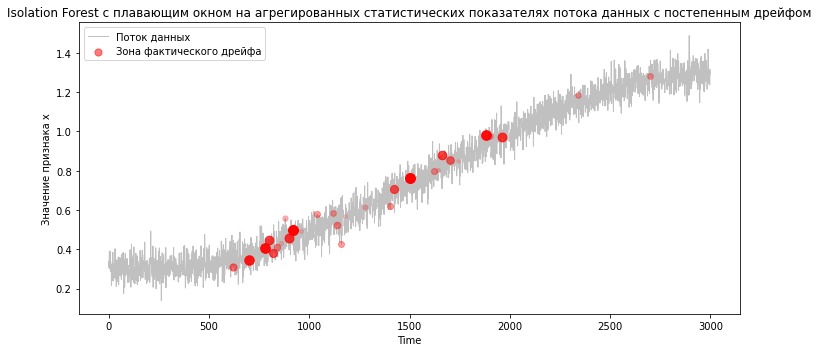

In [60]:
fig = plt.figure(figsize=(10,5), tight_layout=True)
plt.title('Isolation Forest с плавающим окном на агрегированных статистических показателях потока данных с постепенным дрейфом')
plt.xlabel('Time')
plt.ylabel('Значение признака x')
plt.plot(ds_slow, label='Поток данных', color='silver', linewidth=1)
for index, x in enumerate(outlier_index_full):
    plt.scatter(x = x, y = values[index], c = 'red', alpha = normalized_volume[index], s=normalized_volume[index]*100, 
                zorder=2, label='Зона фактического дрейфа' if index == 0 else None)
plt.legend()
plt.show()